# Phys 381 Final
Ken Sharman

April 14th, 2018

Student ID # 00300185

## Introduction

We are given access to the 'Keeling Curve' dataset. This is a record of carbon dioxide concentrations at Mauna Loa Observatory, Hawaii. The data collection started in 1958 and continuous to-date. 

Upon first inspection, we see that there are 3 different sets for each measurement date; average, interpolated, and trend counts of $C0_2$ expressed as a mole fraction in the dry air. The interpolated set is required to fill in some missing data points (see below). Note that the date is expressed in years only format, the months and days have been converted to partial years. The task at hand is to produce various fits for the data.

While the text file includes a brief description on the interpolation method, it by no means goes into detail. Initially, this gave rise to some suspicion towards the interpolated and trend sets. After a few moments of consideration, it was concluded that the methods utilized by the group that have presented this data are without a doubt superior to anything I could produce at this stage of my career. However, I will make an effort in this area and see what I can get out of it.

Firstly, we note a passage from the text file:

"If there are missing days concentrated either early or late in the month, the monthly mean is corrected to the middle of the month using the average seasonal cycle.  Missing months are denoted by -99.99."

I will start with the average count set but will need to use some sort of method to interpolate the missing values.

After some research [1] it appears there are a few factors to keep in mind when numerically interpolating between experimental values. In general, data fitting can be viewed as global or local. In global fits, a single function is used to represent the entire data set. Global interpolations, such as a function that passes through all data points, are usually not ideal. Fitting a function such that it passes through all points, may lead to a fit that shows nonphysical behavior. This leads to the general rule of thumb that if you must interpolate, keep it local. 

Assuming that the dependent variable is the function $g(x)$, with the tabulated values $g_i=g(x_i)$, and assuming that $g(x)$ can be approximated as an $(n-1)$ degree polynomial, we can model the relationship as follows:

$$g_i(x) \approx a_0+a_1x+a_2x+ \dots + a_{n-1}x^{n-1} \quad,\quad (x\approx x_i)$$

To interpolate this data point we will use the closed form expression that directly fits this $(n-1)$ order polynomial. This is known of the Lagrange interpolation polynomial [2].

$$g(x) \approx g_1 \lambda_1(x)+ g_2 \lambda_2(x) + \dots + g_n \lambda_n(x)$$

$$\lambda_i = \prod_{j(\neq i )=1}^{n} \dfrac{x-x_j}{x_i-x_j}$$

We will try to interpolate the missing data points in the "average" column of the data file using the Lagrange method.

In [1]:
# Import the standard packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Task 1
First, we will read the data in the text file (saved to disk), by creating an input stream. The introduction text is skipped, and each column of data is stored in a multi-dimensional numpy array.

In [2]:
# Retrieve the columns of data in the text file
# Sourced from: ftp://aftp.cmdl.noaa.gov/products/trends/co2/co2_mm_mlo.txt
filename = 'co2_mm_mlo.txt'
data = np.genfromtxt( filename, skip_header=72, max_rows=792, usecols=(0,1,2,3,4,5), 
                     names=['year', 'month', 'ddate', 'average','interpolated', 'trend'] )

Now that we have the data separated into subsets, we will define a function that locates the missing month and another that pulls the surrounding data for a given month (required for the Lagrange method).

As an experiment, we will use two data points before and two points after this missing value. There are three consecutive missing months in the set. We will write the function in such a way that it does not use surrounding values if they are missing. For simplification, these points will simply have 2 values to provide to the interpolation process. Clearly, this is not the most robust method, however it should prove to be a satisfactory starting point.

In [3]:
def locateMissingMonths(dataSet=data):
    '''
    Function checks a data set for entries equal to -99.99, which indicates a missing data point.
    A list of indices corresponding to the missing values is returned.
    
    Parameters:
        dataSet: List of data to be analyzed
    Returns:
        List of indices for missing entries
    '''
    
    # Use list comprehension to locate the entries equal to -99.99
    # Indices of these entries are stored in a list and returned
    return [i for i, x in enumerate(dataSet['average']) if x == -99.99]
    
    
def getSample(index, dataSet=data):
    '''
    Function is to be used in Lagrange interpolation process. Given the index, we wish to use the neighboring 4 data points
    (so long as they are not themselves missing data points). For each useable measurement, a 2-tuple is created and added
    to the return list. The elements of the tuple are the decimal date and the average CO2 count.
    
    Parameters:
        index: Entry number in data set corresponding to point we are interpolating
        dataSet: List of data to be analyzed
    Returns:
        List of indices for missing entries
    '''
    
    date_list = [] # Decimal Dates of points used in interpolation
    averageCount_list = [] # CO2 counts used in interpolation 
    
    # If neighboring 4 measurements are not missing, then for each measurement: create a 2-tuple 
    # that contains the decimal date and the count form the average column
    for row in data[index - 2:index + 3]:
        
        if row['average'] > 0:
            
            date_list.append(row['ddate'])
            averageCount_list.append(row['average'])
            
    data_subSet = [i for i in zip(date_list, averageCount_list)]
    
    return data_subSet

In [4]:
def lagrangeCoefficient(term,sub_set, x):
    '''
    Function calculates the coefficient of a term in the Lagrange Interpolation Polynomial. General formula provided in 
    the intoduction section.
    
    Parameters:
        term: data point in close proximity to the interpolation point
        sub_set: set of all data points used in the interpolation process
    Returns:
        product: Coefficient of polynmial term
    '''
    i = term
    product = 1
    for j in range(len(sub_set)):
        
            if j != i:
                product *= (x - sub_set[j][0]) / ( sub_set[i][0] - sub_set[j][0] )
                
    return product

def interpolate(sub_set, x):
    '''
    Function calculates the Lagrange Interpolation Polynomial at specified value of x (decimal date). General formula 
    provided in the introduction section.
    
    Parameters:
        sub_set: Neighboring data of interpolation point
        x: The decimal date of the missing CO2 count
    Returns:
        sum: Lagrange interpolated value
    '''
    sum = 0
    
    # Loop corresponds to the polynomial equation described in the introduction
    for i in range(len(sub_set)):
        sum += ( lagrangeCoefficient(i, sub_set, x) * sub_set[i][1] ) 
    return sum

Now that I have implemented the required functions to perform the Lagrange Interpolation process, we should check the results against the NOAA data.

In [5]:
# import panads to create a table displaying results
import pandas as pd

# Locate the missing moths
index_of_missing = locateMissingMonths()

# Declare lists for decimal date, lagrange and NOAA interpolation for missing points 
dates_of_missing = []
lagrange_inter = []
NOAA_inter = []

# For each missing point, save date and interpolated values
for index in index_of_missing:
    data_subSet = getSample(index)
    dates_of_missing.append(data['ddate'][index])
    lagrange_inter.append( np.round(interpolate(data_subSet, data['ddate'][index]), 2 ) ) 
    NOAA_inter.append(data[index]['interpolated'])

# Dataframe used to present our results
df1 = pd.DataFrame({
    'Decimal Date': dates_of_missing,
    'Lagrange Interpolated (ppm)': lagrange_inter,
    'NOAA Interpolated (ppm)': NOAA_inter
})
print('Compare NOOA/ Lagrange methods of Interpolating Missing Keeling Curve Points\n')
print(df1)

Compare NOOA/ Lagrange methods of Interpolating Missing Keeling Curve Points

   Decimal Date  Lagrange Interpolated (ppm)  NOAA Interpolated (ppm)
0      1958.458                       316.85                   317.10
1      1958.792                       312.75                   312.66
2      1964.125                       320.82                   320.07
3      1964.208                       320.91                   320.73
4      1964.292                       322.61                   321.77
5      1975.958                       330.45                   330.59
6      1984.292                       346.82                   346.84


I would be lying if I said I wasn't surprised at how close the values are- given the range in the original file. It appears only using 2 neighboring points to interpolate the missing month that was surrounded by 2 missing values didn't blow up the process. Accounting for this may produce closer results, however we will run with the process "as-is" and see what comes of it. 

Next, we need to replace the missing points with the new calculated values. We will define a function that performs the entire process and replaces the missing values with the new values as we iterate through the list.

In [6]:
# Second reference variable of original data set for testing purposes
filename = 'co2_mm_mlo.txt'
data2 = np.genfromtxt( filename, skip_header=72, max_rows=792, usecols=(0,1,2,3,4,5), 
                     names=['year', 'month', 'ddate', 'average','interpolated', 'trend'] )

def interpolate_missing_data(dataSet=data2):
    '''
    Function locates months where the average CO2 count is missing and replaces it will the Lagrange interpolated
    value, using several helper functions.
    
    Parameters:
        dataSet: List of data to be analyzed
        
    Returns:
        dataSet: List of data where the missing months have been replaced by Lagrange interpolated values
    '''
    # First locate missing months
    index_of_missing = locateMissingMonths(dataSet)
    
    # For each missing month; get sample of surrounding data, interpolate, and replace with this new value
    for index in index_of_missing:
        data_subSet = getSample(index)
        new_value = np.round(interpolate(data_subSet, dataSet['ddate'][index]), 2)
        data2['interpolated'][index] = new_value
    
    return dataSet

A plot of both interpolated lists versus decimal date will provide some qualitative information on how successful this attempt was at filling in the missing months.

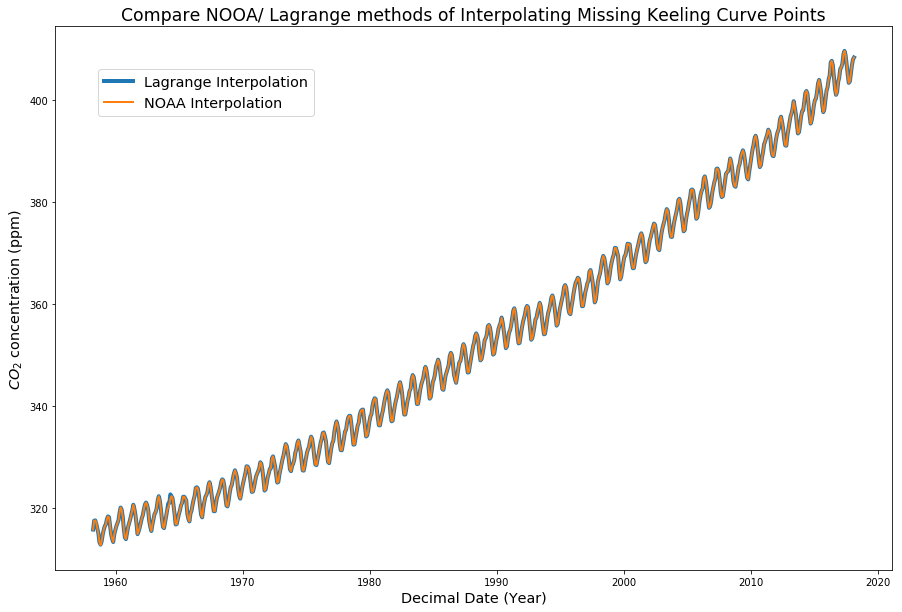

In [7]:
# Gather Lagrange and NOAA interpolated data sets for ease of plotting
sets = [interpolate_missing_data(), data]
# Define and Increase linewidth as the curves are nearly identical and they overlap
line = 4

fig = plt.figure(figsize=(15,10))
# Plot both interpolated sets superimposed on figure
for set in sets:
    plt.plot(set['ddate'], set['interpolated'], linewidth = line)
    line=2 # Reduce linewidth after fist curve is plotted
# Define Legend tags
legend_labels = ['Lagrange Interpolation', 'NOAA Interpolation']

# Customize graph
plt.title('Compare NOOA/ Lagrange methods of Interpolating Missing Keeling Curve Points', fontsize='xx-large')
plt.xlabel('Decimal Date (Year)', fontsize='x-large')
plt.ylabel('$CO_2$ concentration (ppm)', fontsize='x-large')

plt.legend(legend_labels, loc=2, fontsize='x-large', borderaxespad=3)
plt.show()

As mentioned in the comments above, the linewidth of the first curve was increased as both curves are nearly identical to each other. It should be noted that there appears to be some deviation between the sets in 1964, however overall, they appear quite close to each other.

Now we must remove the seasonal fluctuations. For simplicity I am going to simply create a list where the entries are the average of counts separated by 6 months. Based on the sinusoidal like nature of the above plot, this should hopefully produce the results we are looking for.

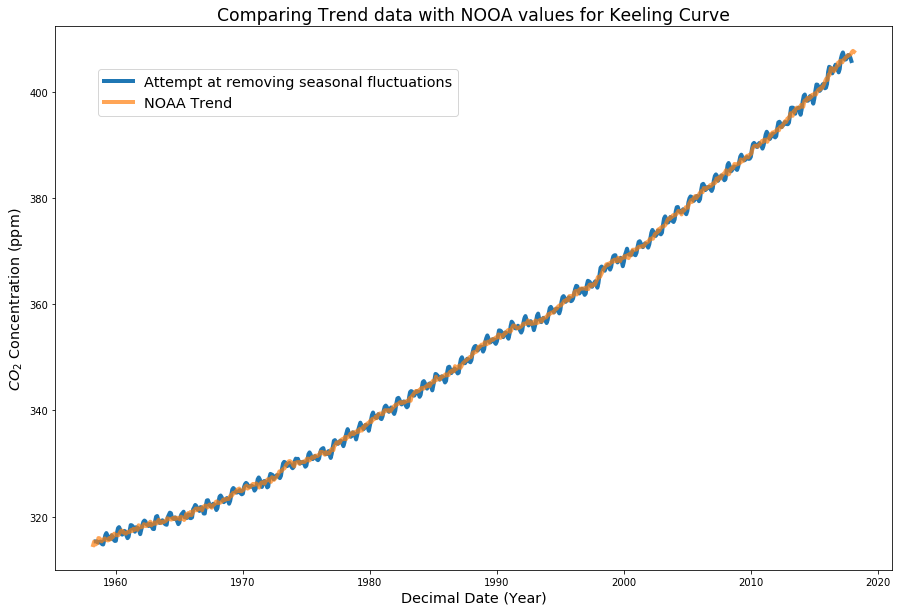

In [8]:
# Define lists for date and trend values that are located in between pre-existing values 
ddate_list = []
trend_list = []

# To move forward 6 months, we need to step forward 6-1 points
steps = 5

# Make date and trend lists, where the entries are the values averaged over 6 months
for i in range(0, len(data) - steps):
    ddate_list.append( ( data2['ddate'][i] + data2['ddate'][i+steps] ) / 2.0 )
    trend_list.append( ( data2['interpolated'][i] + data2['interpolated'][i+steps] ) / 2.0 )
    
# Plot results against NOAA trend values
plt.figure(figsize=(15,10))
plt.plot(ddate_list, trend_list, label='Attempt at removing seasonal fluctuations', linewidth=4)
plt.plot(data['ddate'],data['trend'], label='NOAA Trend', linewidth=4, alpha=0.7)

# Customize Graph
plt.title('Comparing Trend data with NOOA values for Keeling Curve', fontsize='xx-large')
plt.xlabel('Decimal Date (Year)', fontsize='x-large')
plt.ylabel('$CO_2$ Concentration (ppm)', fontsize='x-large')

plt.legend(loc=2, fontsize='x-large', borderaxespad=3)
plt.show()

I was unable to remove the seasonal fluctuations to the extent that I was hoping for. I attempted to use a backward window technique, however this did not produce results that were any closer to the NOAA trend set. None-the-less, I believe this interpolation exercise was worth attempting, as it gave some insight into what sort of manipulations may have been performed on the data.  

### Task 2a
Next, we will attempt to fit a line of best fit to both trend sets. The class notes provided a general method to obtain a best fit curve. The first step to define the nature of the model we intent to fit. In the case of a line of best fit, we would define a function that calculates the dependent variable(s), say $y$, using the form:

$$y=mx+b$$

Where m is the slope, and b is the y-intercept.

Our goal is to use to find coefficients that result in the lowest value of chi-square. While an in-depth statistical analysis is not possible without the proper education, we will simply declare that our goal is to mimize the chi-square, $\chi^2$, as it gives a measure of how tight the curve fits the data points.

$$\chi^2=\dfrac{(expected-observed)^2}{(uncertainty)^2}$$

This expression makes sense since we expect that, on average, the data points will be within uncertainty of the model. We have applied this concept in our laboratories many times, and the notion is not foreign. What is new to us, is how to go about minimizing this value. We have been instructed to use Scipy's optimize.minimize method.

Using the template from the class notes, we define a function that will utilize the linear fit function, pass it coefficients, and return the calculated chi-square value. A source of confusion was with the uncertainty used in this calculation. It was decided to simply use $1$ to stay consistent with the method laid out in the notes. The hope is that this value will produce some meaningful results, but without the proper statistical background we unfortunately cannot come up with a better estimate.

The last step in our process will be to pass the minimize function this fit function, along with a "best guess" of the linear coefficients (used as a starting point in the chi-square minimizing process). The function will return parameters corresponding to the coefficients that effectively minimize the chi-square value. These coefficients can then be used to plot a line of best fit, which we can compare against a scatter plot of the data.

Note that we will comment on the chi-square values at the end of this document. At that point we will have several models for which we can compare against one-another.

Let's go ahead and define the functions used in this week's set of notes. We will use these to obtain linear fit coefficients for both sets of seasonally corrected values (Lagrange and NOOA).

In [9]:
import scipy.optimize

def linear_model(x, param):
    """ 
    Function models linear fit.
    
    Parameters:
        x: Dependent variable(s)
        param: 2-tuple of slope and intercept
        
    Returns
        slope * x + intercept
    """
    
    # Unpack 2-tuple with coefficients
    slope, intercept = param

    return slope*x + intercept

When defining the function that calculates the chi-square value, we will be proactive and include a parameter (String type) that indicates which model we are using. Note that the control structures (and their code blocks) in this function were added as we worked through the analysis. Thus, they may not make sense until later in the document.

Note that the sum of chi-square calculations is divided by the number of data points. This is an attempt to normalize the chi-square value, which is necessary when comparing multiple values.

In [10]:
def fit_func(param, *args):
    """ 
    Function calculates chi-square value for a dataset and fit model.
    
    Parameters: 
        param: Dependent on fit model (all of type float)
                If args[-1] == 'linear':
                    2-tuple has slope and intercept
                If args[-1] == 'periodic' OR 'sine'
                    4-tuple has ampltidue, period, offset, phase
        args:   set of independent values, set of corresponding dependent values, String indicating
                fit model ('linear', 'periodic', or 'sine')
    
    Returns
        chi: Sum of Chi-square values scaled down by length of dependent variables  
    """
    
    # Fit models are explained as they appear in document. Method for each case is the same-
    # Calculate and return chi-square value for dataset and coefficients passed as parameters
    if args[-1] == 'linear':
        slope, intercept = param
        x, y_data = args[:-1]
        y_model = linear_model(x, (slope, intercept))
        residuals = y_model - y_data
        chi = np.sum( residuals**2 ) / len( residuals )
    
    if args[-1] == 'periodic':
        amplitdue, period, offset, phase = param
        x, y_data = args[:-1]
        y_model = periodic_fit(x, (amplitdue, period, offset, phase))
        residuals = y_model - y_data
        chi = np.sum( residuals**2 ) / len( residuals)
    
    if args[-1] == 'sine':
        amplitdue, period, offset, phase = param
        x, y_data = args[:-1]
        y_model = sine_fit(x, (amplitdue, period, offset, phase))
        residuals = y_model - y_data
        chi = np.sum( residuals**2 ) / len(residuals)
    
    return chi

We will now use the linear_model and fit_func functions to determine the coefficients corresponding to the lines of best fit, for both interpolated datasets.

In [11]:
# LAGRANGE INTERPOLATED/ CORRECTED DATA SET

# Cast Lagrange data to numpy array
lagrange_x = np.array(ddate_list)
lagrange_y = np.array(trend_list)

# Super rough (qualitative) guess based on graphs above 
linear_param_guess = [1.0, 300]

# Run minimize using function defined above to produce slope/ intercept that represent line of best fit
lagrange_params = scipy.optimize.minimize(fit_func, linear_param_guess, (lagrange_x, lagrange_y, 'linear'), method='Nelder-Mead' )

In [12]:
# NOAA TREND DATA SET

# Define x-y values to be used in minimizing process
NOAA_x = np.array(data['ddate'])
NOAA_y = np.array(data['trend'])

# Run minimize using function defined above to produce slope/ intercept that represent line of best fit
NOAA_params = scipy.optimize.minimize(fit_func, linear_param_guess, (NOAA_x, NOAA_y, 'linear'), method='Nelder-Mead' )

# Using the calculated parameters and dates, produce a list of CO2 counts that lie on line of best fit
lagrange_linear_model = linear_model(lagrange_x, lagrange_params.x)
NOAA_linear_model = linear_model(data['ddate'], NOAA_params.x)

In [13]:
# Equation for lines of best fit (displayed on graphs below)
m1 = np.round(lagrange_params.x[0], 2).__str__()
b1 = np.round(lagrange_params.x[1], 2).__str__()
line1 = 'y = ' + m1 + ' * x + ' + b1

m2 = np.round(NOAA_params.x[0], 2).__str__()
b2 = np.round(NOAA_params.x[1], 2).__str__()
line2 = 'y = ' + m1 + ' * x + ' + b1

print('Lagrange Method:\n\t' + line1)
print('NOOA DATA:\n\t' + line2)

Lagrange Method:
	y = 1.54 * x + -2713.07
NOOA DATA:
	y = 1.54 * x + -2713.07


Not surprisingly (considering only 5 data points were missing) we came up with the same equations for the lines of best fit for each method.

Let's plot these lines along with the data.

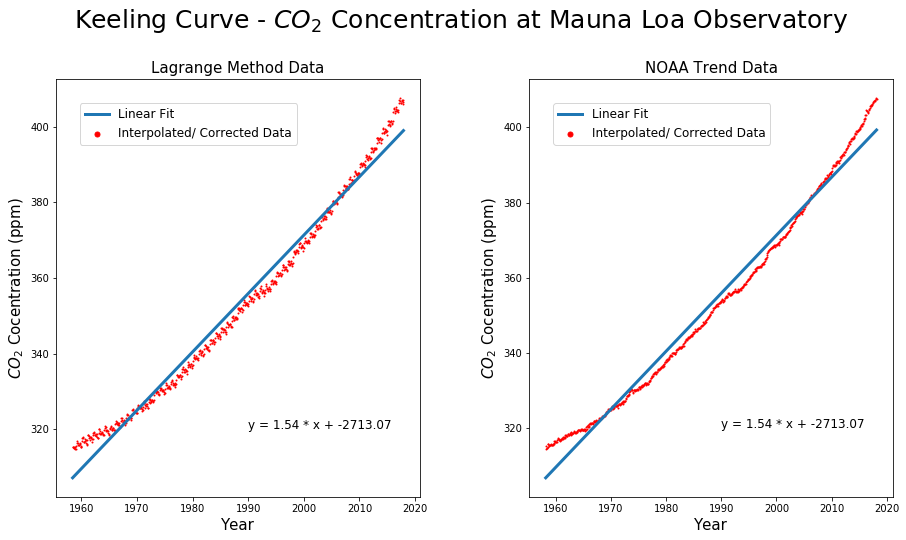

In [14]:
# Plot each data set and line of best on its own subplot
plt.figure(figsize=(15,10))
plt.suptitle('Keeling Curve - $CO_2$ Concentration at Mauna Loa Observatory', fontsize=25)

# LAGRANGE METHOD
# Title, axis labels, equation of line
ax1 = plt.subplot(1,2,1)
ax1.set_title('Lagrange Method Data', fontsize=15)
ax1.set_xlabel('Year', size=15)
ax1.set_ylabel('$CO_2$ Cocentration (ppm)', size=15)
ax1.text(1990, 320, line1, fontsize=12)
# Plot data as scatter plot and superimpose line of best fit
ax1.scatter(ddate_list, trend_list, s=1, c="red", label='Interpolated/ Corrected Data')
ax1.plot(ddate_list, lagrange_linear_model, label='Linear Fit', linewidth=3)
# Add legend
ax1.legend(fontsize='large', borderaxespad=2, markerscale=5)

# NOAA DATA
# Title, axis labels, equation of line
ax2 = plt.subplot(1,2,2)
ax2.set_title('NOAA Trend Data', fontsize=15)
ax2.set_xlabel('Year', size=15)
ax2.set_ylabel('$CO_2$ Cocentration (ppm)', size=15)
ax2.text(1990, 320, line2, fontsize=12)
# Plot data as scatter plot and superimpose line of best fit
ax2.scatter(data['ddate'], data['trend'], s=1, c="red", label='Interpolated/ Corrected Data')
ax2.plot(data['ddate'], NOAA_linear_model,  label='Linear Fit', linewidth=3)
# Add legend
ax2.legend(fontsize='large', borderaxespad=2, markerscale=5)

# Set subplo spacing
plt.subplots_adjust(wspace=0.3, bottom=0.3)
plt.show()

Using the scatter plots highlights the differences between my interpolated data and that of the NOAA. Using the minimize function is certainly more gratifying than using excel or logger pro, and the next step would be to determine the uncertainty in the fit parameters. This however, is an exercise for another day.

### Task 2b
It may be useful to analyze the $C0_2$ concentrations over the course of single year. In this case we would of course use the interpolated data, as the trend set removes the seasonal fluctuations. Due to the seasonal dependence of vegetation, we expect that the concentrations may appear periodic in nature, especially over the relatively short interval of one year. We can attempt to fit the data from 2000 to a cosine model and plot the results to see if this is reasonable.

To do so, we must define a periodic fit function and use minimize to determine the amplitude, period, offset, and phase coefficients that result in the lowest chi-square value.

First, we will isolate to data from 2000 (simply for ease of manipulation) using the NOAA interpolated set. We can make a series of rough guesses for what the parameters may be. We will continue this analysis without the use of the Lagrange method, as the previous results indicated these sets are comparable.

In [15]:
# Declare sets for decimal date and interpolated CO2 concentration for the year 2000
ddate_2000 = []
interpolated_2000 = []

# Extract the data from the larger data set
for x in range(len(data)):
    if 2000< data['ddate'][x] < 2001:
        ddate_2000.append(data['ddate'][x])
        interpolated_2000.append(data['interpolated'][x])

# Rough estimate of the amplitude is half peak to peak amplitude
amplitude = ( np.max(interpolated_2000) - np.min(interpolated_2000) ) / 2.0
# Period estimate is date range
period = ( np.max(ddate_2000) - np.min(ddate_2000) )
# Offset estimate is the average value of concentrations
offset = sum(interpolated_2000) / len(interpolated_2000)
# Phase estimate is unkown and will use zero
phase = 0.01

# Make a list of the parameter estimates
periodic_param_guess = [amplitude, period, offset, phase]

To use the minimize function we added a periodic case to fit_func defined above. We also need to define a function that returns the dependent variable(s) for this cosine fit. The add_offset parameter has been added to the following function to add/remove the DC offset of the wave. The feature will be used in the next task and can be disregarded for the moment.

In [16]:
def periodic_fit(x, params, add_offset=True):
    """ 
    Function models periodic cosine fit.
    
    Parameters:
        x: Dependent variable(s)
        param: 4-tuple of amplitude, period, offset, phase
        add_offset: Indicates if a DC offset is desired. Default is 'True'
        
    Returns
        amplitude * cos(2*pi/period + phase)
        Offset is added to return if indicated with 'True' parameter
    """
    # Unpack 4-tuple with fit coefficients
    amplitude, period, offset, phase = params
    # Calculate angular frequency for readability sake
    omega = 2.0*np.pi / period
    
    if add_offset==True:
        return amplitude*np.cos(omega*x + phase) + offset
    else:
        return amplitude*np.cos(omega*x + phase)

Using the fit function and this cosine function, the minimize process will determine "best" coefficients.

In [17]:
# Cast year 2000 data to numpy array
ddate_2000 = np.array(ddate_2000)
interpolated_2000 = np.array(interpolated_2000)

# Run minimize using function defined above to produce cosine model coefficients
periodic_params = scipy.optimize.minimize(fit_func, periodic_param_guess, (ddate_2000, interpolated_2000, 'periodic'), method='Nelder-Mead' )

Next, we plot data from 2000 and superimpose the curve of best fit obtained using coefficients calculated above.

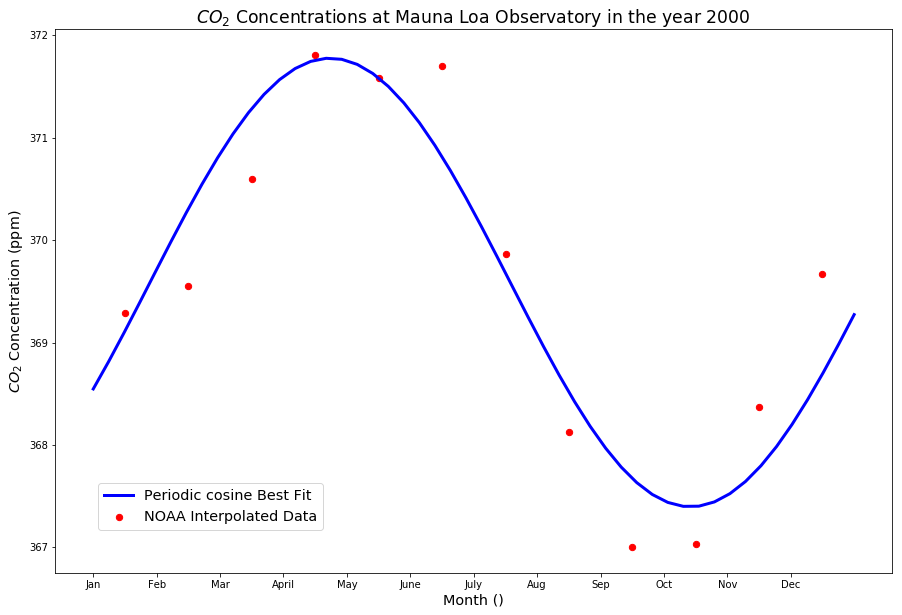

In [18]:
# Rather than only using 12 data points to plot curve of best fit, we will
# use to linspace to get a smoother curve
x = np.linspace(2000, 2001)

# Calculate dependent variable list
y_vals = periodic_fit(x, periodic_params.x)

plt.figure(figsize=(15,10))
ax = plt.subplot()

# Plot data form 2000 as scatter plot
plt.scatter(ddate_2000, interpolated_2000, s=40, c="red", label='NOAA Interpolated Data')
# Plot periodic curve of best fit
plt.plot(x, y_vals, c='blue', label='Periodic cosine Best Fit', linewidth=3)

# Customize Graph
plt.title('$CO_2$ Concentrations at Mauna Loa Observatory in the year 2000', fontsize='xx-large')
plt.xlabel('Month ()', fontsize='x-large')
plt.ylabel('$CO_2$ Concentration (ppm)', fontsize='x-large')

# Set the x ticks to be the months of the year
ticks = [(x/12)+2000.0 for x in np.arange(0,12,1)]
xlabels = ['Jan', 'Feb', 'Mar', 'April', 'May', 'June', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
ax.set_xticks(ticks)
ax.set_xticklabels(xlabels)

# Add legend
plt.legend(loc=3, fontsize='x-large', borderaxespad=3)
plt.show()

First off it is worth noting that the $CO_2$ concentration fluctuates over a relatively small range, when compared to the increase we have seen in the past 50 years. The magnitude (roughly +/-3 ppm) is surprisingly small, however Maui winters are not the same as we see in Calgary.
The periodic fit, as produced by the minimize function, seems to follow the data points. With their only being 12 points, it is difficult to say how tight a fit it is. Further, it isn't hard to imagine that many factors influence the concentration over such a brief time.


### Task 2c
Let's take this periodic model and apply it over the course of the entire data set. We know from the above analysis that the concentration levels are in general, increasing year after year. Adding a linear component to the yearly fluctuation model should result in a model that approximates the interpolated (average) data set. We will combine the two models above and compare against the interpolated data. 

By removing the DC offset of the periodic curve, we can simply combine the linear and periodic models. In doing so, we won't obtain a chi-square value for the combined fit, however after plotting against the NOAA average set, it is obvious that the model differs a significant amount from the data. A visual inspection is enough to know that our fit would not be an adequate model for many interpolation or extrapolation processes.

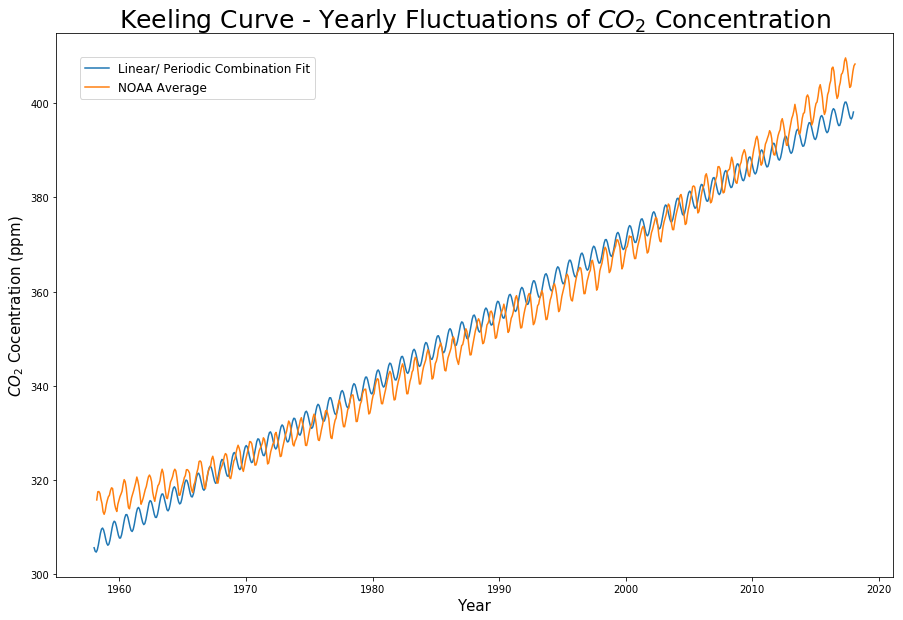

In [19]:
# Create a list a dates ranging from 1958-2018
x = np.linspace(1958, 2018, 12*(2018-1958))

# Customize plot
plt.figure(figsize=(15,10))
plt.title('Keeling Curve - Yearly Fluctuations of $CO_2$ Concentration', fontsize=25)
plt.xlabel('Year', size=15)
plt.ylabel('$CO_2$ Cocentration (ppm)', size=15)

# Use list comprehension to combine linear and periodic models - remove offset from periodic
combined = [sum(x) for x in zip(linear_model(x, NOAA_params.x), periodic_fit(x, periodic_params.x, False))]

# Plot expected and observed data
plt.plot(x, combined, label='Linear/ Periodic Combination Fit')
plt.plot(data['ddate'], data['interpolated'], label='NOAA Average')

# Add legend
plt.legend(fontsize='large', borderaxespad=2, markerscale=5)

plt.show()

We see that the actual data does not appear to increase linearly. The periodic component of the modeled curve appears to match the data quite well in terms of period, however the amplitdue is smaller than the average data set.

To recap: we have experimented with using linear and periodic models to fit a particular set a data. In doing so, we have constructed a curve that was expected to be a reasonable model of the average data set. For the final task, let's see if we can produce a model that provides a decent curve of best fit to the entire NOAA trend set.

### Task 3
The trend set will follow the same sort of increase observed with the average data in the previous graph. After some online research it appears that a number of people believe that the $CO_2$ levels are increasing exponentially. I prefer an optimistic outlook and would guess that the levels will follow more of a logistic shaped curve, as we find some control to the emissions on a global level.
If we consider a sine function over a quarter period, we have something that resembles a logistic curve. Let's apply this sine model to the trend set. 

Following the same procedure as the first two fits, we define a sine fit function, run the optimize method to determine the coefficients that reduce the chi-square value, and plot these resultant model against our data.

In [20]:
def sine_fit(x, params):
    '''
    Function models periodic sine fit
    
    Parameters:
        x: Dependent variable(s)
        param: 4-tuple of amplitude, period, offset, phase
        
    Returns
        amplitude * sin(2*pi/period + phase)
    '''
    
    # Unpack 4-tuple of fit coefficients
    amplitude, period, offset, phi = params
    # Calculate angular frequency for readability sake
    omega = 2.0*np.pi / period
    
    return amplitude*np.sin(omega*x + phi) + offset 

For the linear and cosine fits I have simply used the output of the minimize function, without comment, as discussion regarding the chi-square values was left to the end of the document. Here we will show the output of minimize and discuss the results. This discussion will include the following estimates for the periodic parameters.

In [21]:
sine_param_guess = [100.0, 250, 500.0, 0.0]  # amplitude, period, offset, phase

sine_params = scipy.optimize.minimize(fit_func, sine_param_guess, (data['ddate'], data['trend'], 'sine'), method='Nelder-Mead' )
print(sine_params)

 final_simplex: (array([[ 7.75511222e+01,  2.51344750e+02,  3.91167832e+02,
        -5.78823675e-03],
       [ 7.75511221e+01,  2.51344748e+02,  3.91167809e+02,
        -5.78823816e-03],
       [ 7.75511644e+01,  2.51344756e+02,  3.91167917e+02,
        -5.78822815e-03],
       [ 7.75511403e+01,  2.51344749e+02,  3.91167824e+02,
        -5.78823503e-03],
       [ 7.75511500e+01,  2.51344752e+02,  3.91167856e+02,
        -5.78823424e-03]]), array([1.08475156, 1.08475156, 1.08475156, 1.08475156, 1.08475156]))
           fun: 1.0847515587647873
       message: 'Optimization terminated successfully.'
          nfev: 333
           nit: 188
        status: 0
       success: True
             x: array([ 7.75511222e+01,  2.51344750e+02,  3.91167832e+02, -5.78823675e-03])


For the linear and cosine fits we were able to send the minimize function estimates for the parameters, without issue. In this case, my first guess resulted in a message "Maximum number of function evaluations exceeded". Initially, it was assumed that this meant the guess was too far from the ideal coefficients. After playing around with the coefficients it was noted that minimize could successfully return parameters over a wide range- too wide in fact. This means that the success of the minimize function gives no indication of the validity of the best fit parameters. It other words, we could successfully run the function for a period of 200 years, 300 years, or even 400 years. Unfortunately, my level of understanding in curve fitting does not provide the most in-depth analysis of this situation.

To apply some logic here, the period was adjusted until the lowest chi-square value was obtained. The best explanation I can come up with is that we would require data over the course of (at least) a full period, to "force" the curve to a period and/ or amplitude. This may make sense, since it is highly unlikely that the long term $CO_2$ concentration will exhibit sine wave properties, and the data we have would not produce an ideal sine fit. None-the-less, we will continue with the model and attempt to extract some meaningful results.

Let's plot the model against the trend data set.

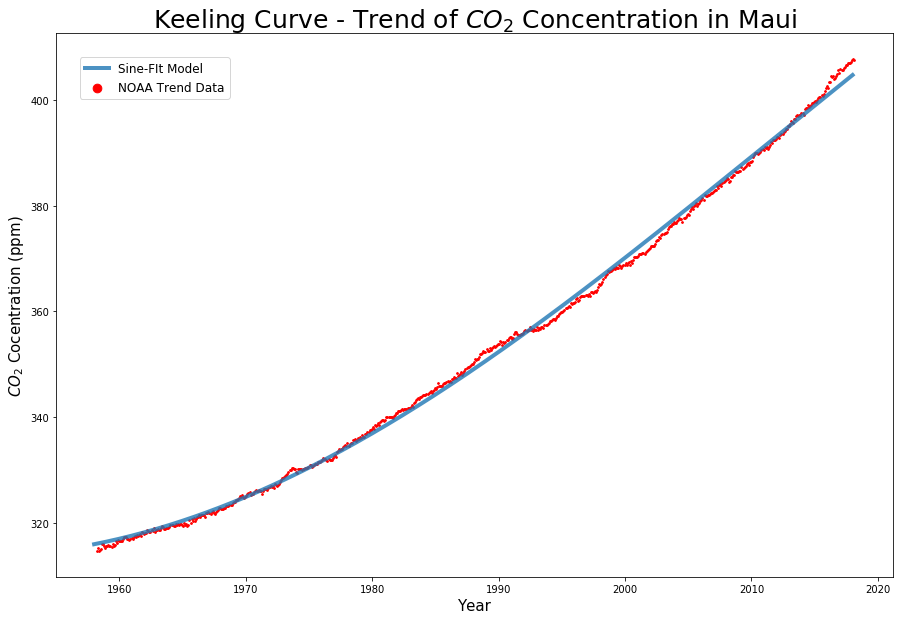

In [22]:
# Calculate set of independent variables representing the CO2 concentrations
y_sine = sine_fit(x, sine_params.x)

plt.figure(figsize=(15,10))
plt.title('Keeling Curve - Trend of $CO_2$ Concentration in Maui', fontsize=25)
plt.xlabel('Year', size=15)
plt.ylabel('$CO_2$ Cocentration (ppm)', size=15)

# Plot best fit curve against NOAA trend dataset
plt.plot(x, y_sine, label='Sine-FIt Model', linewidth=4, alpha=0.8)
plt.scatter(data['ddate'], data['trend'], s=3, c='red', label='NOAA Trend Data')

# Add legend
plt.legend(fontsize='large', borderaxespad=2, markerscale=5)
plt.show()

From the above plot we can see that the sine fit does a relatively decent job at following the data points. From the middle portion of the data it almost appears as though there is a second periodic nature to this curve. Including this in our curve may produce a curve that is tighter to the data points, however it could be considered trying to force the relationship, if the fluctuation is due to some random variable(s).

The last 2 or 3 years may cause some concern, as the data significantly deviates from the curve. When it comes to this data fitting exercise, it may indicate that the relationship is more exponential in nature. When it comes to the world we live in, that is scary. We see an increase in the rate of emissions- during a time where efforts are being made to mitigate the emission (at least that's the impression I get from the media).

Returning our attention to the chi-square values; let's print the values obtained and compare.

In [23]:
# Define a dataframe to display the results of the chi-square values
# calculated for each fit model
df = pd.DataFrame({
    'Chi-Square' : [NOAA_params.fun, periodic_params.fun, sine_params.fun],
    'Model': ['Linear', 'Cosine', 'Sine'],
    'Date': ['ALL', '2000', 'ALL']
})
print(df)

   Chi-Square  Date   Model
0   11.937521   ALL  Linear
1    0.328017  2000  Cosine
2    1.084752   ALL    Sine


As this is my introduction to chi-square values have little frame of reference however these values are consistent with my understanding to-date. The linear fit was perhaps not the best model for the data, since there is a rather evident curve to the trend.  The result is $\chi^2=11.94$

On the other end of the spectrum we have $\chi^2=0.33$ for the cosine fit over the course of a single year. With only a few data points it is not surprising that the value is not closer to the ideal value of one. The fact that it is less than one raised some concern, and it was concluded this was produced due to the method we used to normalize the chi-square sum (by dividing by number of data points). Down the line, if I am to further my curve fitting knowledge, it is necessary to investigate better ways of normalizing the chi-square.

Finally, fitting the trend data to a sinusoidal curve was more of an exercise of trial and error. The parameter estimates were adjusted until the lowest chi-square was produced, $\chi^2=1.08$. This looks great upon initial inspection but recall that there was a little bit of confusion when calling minimize on this model. Uneducated speculation will serve little purpose here, so let's go ahead and compare our model that one found online.

A quick visit to: http://greenphysicist2.blogspot.ca/2010/02/atmospheric-carbon-dioxide-levels.html will reveal that the author of this report has concluded that by the year 2050, the $CO_2$ concentration levels at Mauna Loa Observatory will be approximately $550\, ppm$. Using our model, we can extrapolate to 2050 and produce an expectation of our own.

In [24]:
expected = int(sine_fit(2050, sine_params.x))

print('Extrapolated carbon-dioxide concentration in the year 2050: ', expected, 'ppm')

Extrapolated carbon-dioxide concentration in the year 2050:  455 ppm


The cosine model we constructed predicts a $CO_2$ concentration that is roughly 100 ppm lower than that of the model compared. This is not surprising as the author used an exponential model to forecast this data point. Given the last few years, the exponential model is not all that unrealistic.

Analyzing this data is scary. It is one thing to see how the IT and computational speeds are increasing at an exponential rate. We have an entirely different thought process when we look at how our "progress" is altering our environment.

## Conclusion

Using the Lagrange interpolation polynomial, we produced values for the missing data that were very similar to the numbers in the average data set. Unfortunately, when attempting to remove the seasonal fluctuations, it was noted that while the fluctuations were smaller in magnitude, they were still there. Without a doubt, a more advanced algorithm would be required to make the trend curve as "smooth" as the NOOA trend data. I still feel going through this exercise was valuable, in that it made my introduction to data analysis more involved. I find this material extremely interesting, as it is a good combination of coding, mathematics, statistics, and awareness of what you are trying to accomplish.

The method of constructing a fit model and then minimizing the associated chi-square value, produced visually pleasing results. The linear fit appeared "centered" on the data points, and the periodic fit appeared to represent the overall fluctuations of the data. When attempting to fit a curve to the entire trend data set, it was noted that different guesses for the parameters would result in different return values. Furthermore, each curve plotted with these varied parameters appeared to fit the data quite nicely. I believe this demonstrates the complexity involved with curve fitting- it is extremely difficult to conclude that the model fits the data. If we apply more knowledge gained from the lab; presumably it is only correct to say that the curve fits the data within a given tolerance, or window.

I will make a couple comments to conclude PHYS 381. I believe this was a course that fit the saying "you get out, what you put into it". I am blown away at how much I learned here. I started the semester not knowing any python, so to be able to create this document is impressive to myself. My old boss had a saying (paraphrased here); "Nonsense in, nonsense out". At the start of the semester if I had applied that to my expectations of computational physics, I would have guessed that if all the input was proper, then the computer would output the correct answer. Clearly, this is not the case. A significant amount of attention must be applied to interpretation of the output. I can only imagine that this concept will be applied at all levels moving forward.

I am looking forward to PHYS 481 - see you in the fall semester!

Ken

## References
[1] Computational Physics, Problem Solving with Python, 3e, Rubin H. Landau, Manuael J. Paez, and Cristian C. Bordeianu

[2] http://mathworld.wolfram.com/LagrangeInterpolatingPolynomial.html

[3] co2_mm_mlo.txt Sourced from: ftp://aftp.cmdl.noaa.gov/products/trends/co2/co2_mm_mlo.txt